In [1]:
#Importing all the neccessary libraries
import pandas as pd
import numpy as np

#Libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import sweetviz as sv

#Libraries for formattting and handling text 
import string
import re

#Library for nltk
import nltk 
import nltk.corpus
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

from collections import defaultdict
from collections import  Counter
stop=set(stopwords.words('english'))

#Library for Splitting Dataset
from sklearn.model_selection import train_test_split

#Library for TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

#Sklearn ml models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import time
#Library for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\VovAz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\VovAz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VovAz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_train=pd.read_csv('C:/Users/VovAz/OneDrive/Desktop/Проект/Disaster/train.csv')
df_test=pd.read_csv('C:/Users/VovAz/OneDrive/Desktop/Проект/Disaster/test.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
print('Sample text from the train dataset:')
df_train['text'].head()

Sample text from the train dataset:


0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [5]:
report_con = sv.analyze([df_train, 'keyword'])

                                             |          | [  0%]   00:00 -> (? left)

In [6]:
report_con.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [7]:
report_con = sv.analyze([df_train, 'target'])

                                             |          | [  0%]   00:00 -> (? left)

In [8]:
report_con.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


EDA shows that there is less than 1% of missing data, 3% of data are unique values.

In [9]:
print('Top 10 of frequently used keywords at disaster tweets: ')
df_train[df_train['target']== 1]['keyword'].value_counts().head(10)

Top 10 of frequently used keywords at disaster tweets: 


derailment           39
wreckage             39
outbreak             39
debris               37
oil%20spill          37
typhoon              37
evacuated            32
suicide%20bombing    32
rescuers             32
suicide%20bomb       32
Name: keyword, dtype: int64

In [10]:
print('Top 10 of frequently used keywords at non-disaster tweets: ')
df_train[df_train['target']== 0]['keyword'].value_counts().head(10)

Top 10 of frequently used keywords at non-disaster tweets: 


body%20bags    40
harm           37
armageddon     37
wrecked        36
ruin           36
deluge         36
explode        35
twister        35
fear           35
siren          35
Name: keyword, dtype: int64

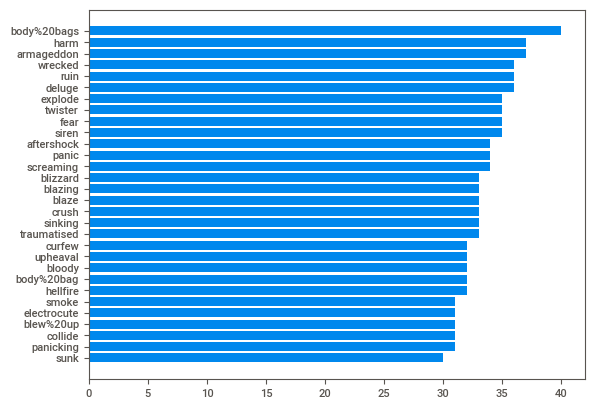

In [11]:
height = df_train[df_train['target']== 0]['keyword'].value_counts(ascending = False)[:30].values
bars = df_train[df_train['target']== 0]['keyword'].value_counts(ascending = False)[:30].index
y_pos = range(len(bars), 0 ,-1) #create descending graph 
 
# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the x-axis
plt.yticks(y_pos, bars)
 
# Show graphic
plt.show()

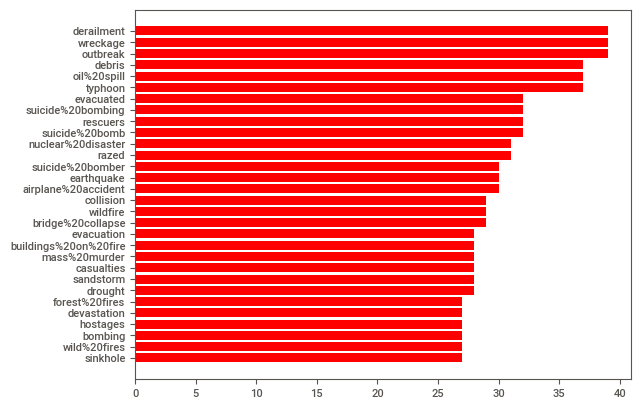

In [12]:
height = df_train[df_train['target']== 1]['keyword'].value_counts(ascending = False)[:30].values
bars = df_train[df_train['target']== 1]['keyword'].value_counts(ascending = False)[:30].index
y_pos = range(len(bars), 0 ,-1)
 
# Create horizontal bars
plt.barh(y_pos, height, color= 'red')
 
# Create names on the x-axis
plt.yticks(y_pos, bars)

# Show graphic
plt.show()

In [13]:
shared_words = df_train[df_train['target']== 0]['keyword'].value_counts(ascending = False)[:30].index.isin(df_train[df_train['target']== 1]['keyword'].value_counts(ascending = False)[:30].index)
shared_words

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

### We observed the most frequntly used keywords at disaster/non-disaster tweets: there is no shared words.

In [14]:
def clean_text(text):
    text=str(text).lower() #converts text to lowercase
    text=re.sub('\d+', '', text) #removes numbers
    text=re.sub('\[.*?\]', '', text) #removes HTML tags
    text=re.sub('https?://\S+|www\.\S+', '', text) #removes url
    text=re.sub(r"["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", "", text) #removes emojis

    text = text.translate(str.maketrans('', '', string.punctuation))    #removes punctuations
    return text

In [27]:
df_train['clean_text']=df_train['text'].apply(clean_text)# apply a clean_text function on 'text' row 
df_train.head(10)# checking
df_test['clean_text']=df_test['text'].apply(clean_text)

In [28]:
# removing stopwords using nltk
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_train.head()
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [29]:
lemma=WordNetLemmatizer()
#transform clear text to lemma
def lemmatizer(text):
    text= ' '.join(lemma.lemmatize(word) for word in text.split(' '))
    return text

df_train['final_text']=df_train['clean_text'].apply(lemmatizer)
df_train.head()
df_test['final_text']=df_test['clean_text'].apply(lemmatizer)

### We cleared the text from punctuations, emojis, hashtags, stopwords and transformed it to lemma. Now it's time to train and test our models.

In [18]:
X=df_train['final_text']
y=df_train['target'].values

In [19]:
from sklearn.model_selection import train_test_split

X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size= 0.2, random_state= 123456,stratify=y) #splitting 

In [20]:
tfidf=TfidfVectorizer()
X_train=tfidf.fit_transform(X_train).toarray()
X_valid=tfidf.transform(X_valid).toarray()


In [21]:
train_start = time.time()
model = RandomForestClassifier() 
hyperparams = [{'n_estimators' : [x for x in range(1, 10)], 
                'max_depth':[x for x in range(1, 20)], 
                'random_state':[123456]}]

clf = GridSearchCV(model, hyperparams, scoring='accuracy')
clf.fit(X_train, y_train)
print("Best hyperparams:")

print(clf.best_params_)
train_end = time.time()
print('Tuning hyperparams time:{}'.format(train_end - train_start))

Best hyperparams:
{'max_depth': 18, 'n_estimators': 5, 'random_state': 123456}
Tuning hyperparams time:529.4150891304016


In [22]:
train_start = time.time()
model = LGBMClassifier() 

hyperparams = [{'num_leaves' : [x for x in range(1, 102, 20)], 
                'max_depth':[x for x in range(1, 12, 2)],
                'random_state':[123456]}]


clf = GridSearchCV(model, hyperparams, scoring='accuracy')
clf.fit(X_train, y_train)
print("Best hyperparams:")

print(clf.best_params_)
train_end = time.time()
print('Tuning hyperparams time:{}'.format(train_end - train_start))

Best hyperparams:
{'max_depth': 11, 'num_leaves': 21, 'random_state': 123456}
Tuning hyperparams time:99.77476501464844


In [23]:
train_start = time.time()
model = DecisionTreeClassifier() 

hyperparams = [{'max_depth':[x for x in range(1, 20)], 
                'random_state':[123456]}]


clf = GridSearchCV(model, hyperparams, scoring='accuracy')
clf.fit(X_train, y_train)
print("Best hyperparams:")

print(clf.best_params_)
train_end = time.time()
print('Tuning hyperparams time:{}'.format(train_end - train_start))

Best hyperparams:
{'max_depth': 19, 'random_state': 123456}
Tuning hyperparams time:718.1346273422241


In [25]:
models = [RandomForestClassifier(max_depth = 18, n_estimators = 5, random_state = 123456), 
          DecisionTreeClassifier(max_depth = 19, random_state= 123456),
          LGBMClassifier(max_depth= 11, num_leaves = 21, random_state= 123456)]


results = []

for model in models: 
    train_start = time.time()  
    model.fit(X_train, y_train)
    train_end = time.time()
    predict_start = time.time()
    pred = model.predict(X_valid)
    predict_end = time.time()
    accuracy = accuracy_score(y_valid, pred)
    results.append({'model_name': model.__class__.__name__, 
                    'training time': train_end - train_start,
                    'prediction time': predict_end - predict_start,
                    'accuracy': accuracy                              
                              })  
              
res = pd.DataFrame(results)
res

,model_name,training time,prediction time,accuracy
0,RandomForestClassifier,0.708219,0.092061,0.686802
1,DecisionTreeClassifier,18.289712,0.062500,0.700591
2,LGBMClassifier,0.469144,0.031246,0.772160


In [35]:
test_frame = tfidf.transform(df_test['final_text']).toarray()
model = LGBMClassifier(max_depth= 11, num_leaves = 21, random_state= 123456)
model.fit(X_train,y_train)
pred = model.predict(test_frame)
submission = df_test[['id']].reset_index(drop=True)
submission['target'] = pred
submission['target']

0       1
1       1
2       1
3       1
4       1
       ..
3258    1
3259    1
3260    1
3261    1
3262    0
Name: target, Length: 3263, dtype: int64

In [36]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [37]:
submission.to_csv('C:/Users/VovAz/OneDrive/Desktop/Проект/Disaster/submission.csv', index=False)